In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import cv2 as cv

## original

In [2]:
import os
#from sklearn.model_selection import train_test_split
def load_preprocessing_data(path,size):
    images_data=[]
    pathes=[]
    c=-1
    labels=[]
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        i=0
        c+=1
        for file in os.listdir(folder_path):
            img_path=os.path.join(folder_path, file)
            pathes.append(img_path)
            i+=1
            labels.append(c)
            if i==300:break
            
    images_data=np.array([cv.resize((cv.imread(i)), size) for i in pathes])
    labels=np.array(labels)
    images_data=images_data.astype(np.float32) / 255.0
    #np.random.shuffle(images_data)
    
    return images_data,labels

In [3]:
path='/kaggle/input/tomatoleaf/tomato/train'   


size=(256,256)
x,labels=load_preprocessing_data(path,size)

## Masks

In [4]:

import os
#from sklearn.model_selection import train_test_split
def load_preprocessing_data(path,size):
    images_data=[]
    pathes=[]
    #c=-1
    #labels=[]
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        i=0
        #c+=1
        for file in os.listdir(folder_path):
            img_path=os.path.join(folder_path, file)
            pathes.append(img_path)
            i+=1
            #labels.append(c)
            if i==300:break
            
    images_data=np.array([cv.resize((cv.imread(i,cv.IMREAD_GRAYSCALE)), size) for i in pathes])
    #labels=np.array(labels)
    images_data=images_data.astype(np.float32) / 255.0
    #np.random.shuffle(images_data)
    
    return images_data


In [5]:
path='/kaggle/input/tomato-leaf-disease-dataset-segmented/train'
size=(256,256)
y=load_preprocessing_data(path,size)

In [6]:
import random

# Assuming x, labels, and masks are lists with the same length
combined = list(zip(x, labels, y))

# Shuffle the combined list
random.shuffle(combined)

# Split the shuffled list back into separate lists
x, labels, y= zip(*combined)

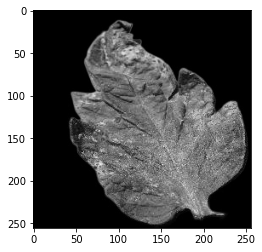

In [7]:
plt.imshow(y[1],cmap='gray')

In [8]:

y=np.array(y)
y=((y/255.0)>0).astype('int')

In [9]:
x=np.array(x)
labels=np.array(labels)

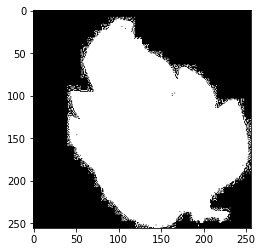

In [10]:
plt.imshow(y[1],cmap='gray')

In [11]:
x_train=x[:2000]
x_val= x[2000:2500]        
x_test= x[2500:]
train_labels=labels[:2000]
val_labels= labels[2000:2500]        
test_labels= labels[2500:]


In [12]:


y_train=y[:2000]
y_val= y[2000:2500]     
y_test= y[2500:]

## U_Net segmentation model

In [13]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [14]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [15]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [16]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)#3

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [17]:
unet_model = build_unet_model()

In [18]:
from tensorflow.keras.losses import BinaryCrossentropy
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),#BinaryCrossentropy()
                   loss="sparse_categorical_crossentropy",#BinaryCrossentropy(),#BinaryCrossentropy(),#"categorical_crossentropy",#"categorical_crossentropy",#"sparse_categorical_crossentropy"
                   metrics=["accuracy"])

In [19]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((2000, 256, 256, 3), (2000, 256, 256), (500, 256, 256, 3), (500, 256, 256))

In [20]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test= tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
x_val= tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [21]:
history=unet_model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5,batch_size=4) #,batch_size=16

Epoch 1/5
500/500 [==============================] - 77s 153ms/step - loss: 0.1511 - accuracy: 0.9410 - val_loss: 0.0925 - val_accuracy: 0.9625
Epoch 2/5
500/500 [==============================] - 77s 153ms/step - loss: 0.1178 - accuracy: 0.9574 - val_loss: 0.1232 - val_accuracy: 0.9522
Epoch 3/5
500/500 [==============================] - 77s 153ms/step - loss: 0.0936 - accuracy: 0.9627 - val_loss: 0.0877 - val_accuracy: 0.9643
Epoch 4/5
500/500 [==============================] - 77s 153ms/step - loss: 0.1083 - accuracy: 0.9612 - val_loss: 0.0975 - val_accuracy: 0.9576
Epoch 5/5
500/500 [==============================] - 77s 153ms/step - loss: 0.0899 - accuracy: 0.9635 - val_loss: 0.0835 - val_accuracy: 0.9656


## Save model

In [22]:
unet_model.save('unet_model.h5', save_format='h5')

In [23]:
import pickle

In [24]:
#pickle.dump(unet_model, open('model.pkl', 'wb'))

In [25]:
unet_model.evaluate(x_test,y_test)

16/16 [==============================] - 5s 316ms/step - loss: 0.0781 - accuracy: 0.9679


[0.0781136155128479, 0.9679427742958069]

In [26]:
import tensorflow as tf


loaded_model = tf.keras.models.load_model('unet_model.h5')

In [27]:
_pred=unet_model.predict(x_test)

In [28]:
pred_=loaded_model.predict(x_test)

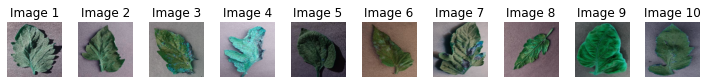

In [29]:
import matplotlib.pyplot as plt

# Assuming images is a NumPy array with shape (num_images, height, width, channels)
# where num_images is the number of images to display
# You can adjust the figure size and layout based on your preference
fig, axes = plt.subplots(nrows=1, ncols=len(x_test[20:30]), figsize=(10, 4))

# Iterate over each image and display it
for i, image in enumerate(x_test[20:30]):
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f'Image {i+1}')  # Set title for each image

plt.tight_layout()  # Adjust layout to make sure titles don't overlap
plt.show()

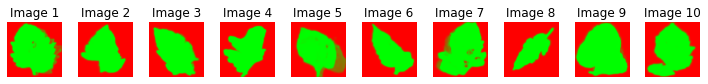

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=len(pred_[20:30]), figsize=(10, 4))

# Iterate over each image and display it
for i, image in enumerate(pred_[20:30]):
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f'Image {i+1}')  # Set title for each image

plt.tight_layout()  # Adjust layout to make sure titles don't overla _pred
plt.show()

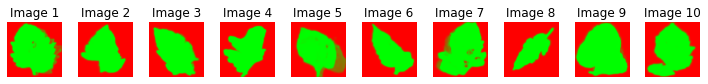

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=len(_pred[20:30]), figsize=(10, 4))

# Iterate over each image and display it
for i, image in enumerate(_pred[20:30]):
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f'Image {i+1}')  # Set title for each image

plt.tight_layout()  # Adjust layout to make sure titles don't overla _pred
plt.show()

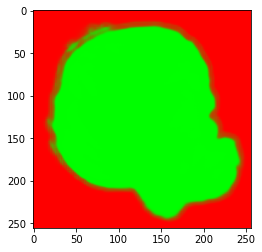

In [32]:
plt.imshow(pred_[0])

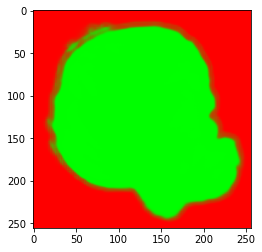

In [33]:
plt.imshow(_pred[0])

## Masked Images

In [34]:
masked_images=[]
for i in range(500):
    img=np. array(x_test[i]) 
    mask=np.array(_pred[i])
    mask=cv.cvtColor(mask,cv.COLOR_BGR2GRAY)
    mask=mask*255
    thresh_, binary_mask = cv.threshold(mask, 128, 255, cv.THRESH_BINARY)
    binary_mask = binary_mask.astype(np.int8)
    masked_image = cv.bitwise_and(img, img, mask=binary_mask)
    masked_images.append(masked_image)
   
    
    #mask = mask.astype(np.int8)

In [35]:
masked_images=[cv.resize(i,(224,224)) for i in masked_images ]
masked_images=np.array(masked_images)

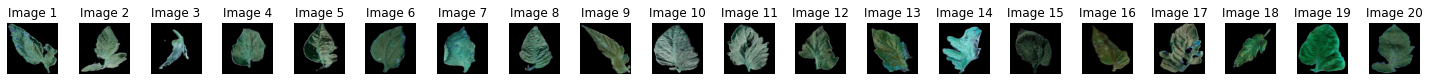

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=len(masked_images[10:30]), figsize=(20, 4))

# Iterate over each image and display it
for i, image in enumerate(masked_images[10:30]):
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f'Image {i+1}')  # Set title for each image

plt.tight_layout()  # Adjust layout to make sure titles don't overla _pred
plt.show()

## Classification Model

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

In [ ]:
# Walk through each directory
dataset = "/kaggle/input/tomato-leaf-disease-dataset-segmented/train/"
walk_through_dir(dataset)

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
len(test_df)

In [ ]:
val_df, test_df = train_test_split(test_df, test_size=0.3, shuffle=True, random_state=1)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input


In [ ]:
###
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
    #validation_split=0.2
)
val_generator=ImageDataGenerator(
    preprocessing_function=preprocess_input
    #validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
train_datagen_vgg = ImageDataGenerator(rescale=1./255,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            horizontal_flip = True,
                                            #verical_flip = True,##
                                            rotation_range= 7,
                                             
                                            )

test_datagen_vgg = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split the data into three categories.
train_images = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    #subset='training'
)

val_images = test_datagen_vgg.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
   # subset='validation'
)

test_images=test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    #shuffle=True,
    seed=42,
    #subset='validation'
)

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=SIZE + [3], weights="imagenet", include_top=False)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:

x = Flatten()(vgg.output)

In [ ]:
num_classes=10

In [ ]:
prediction = Dense(num_classes, activation="softmax")(x)

vgg_model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
vgg_model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
#mobile  vgg  inception  res

In [ ]:
history = vgg_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=19,

)

## save model

In [ ]:
vgg_model.save('classification_model.h5')

In [ ]:

vgg_model.evaluate(test_images)

In [ ]:
pred1 = vgg_model.predict(test_images)
pred1 = np.argmax(pred1,axis=1)

In [ ]:
#masked_image_train=np.array([cv2.resize(i,(224,224)) for i in masked_image_train])

In [ ]:
import tensorflow as tf


loaded_model_class = tf.keras.models.load_model('classification_model.h5')
pred2=loaded_model_class.predict(test_images)
pred2 = np.argmax(pred2,axis=1)

In [ ]:
np.sum((pred1==pred2).astype('int'))